In [7]:
import numpy as np
from matplotlib import pyplot as plt
import pymc3 as pm

plt.style.use('grayscale')
plt.style.use('seaborn-whitegrid')
np.random.seed(0)

In [8]:
arms = [[0, 0], [0, 1], [1, 0], [1, 1]]

In [9]:
class Env(object):
  def p(arm):
    x = arm[0] * 0.2 + arm[1] * 0.8 - 4
    p = 1 / (1 + np.exp(-x))
    return p

  def react(arm):
    return 1 if np.random.random() < Env.p(arm) else 0

  def opt():
    return np.argmax([Env.p(arm) for arm in arms])

In [10]:
class LinUCBAgent(object):
  def __init__(self):
    self.phis = np.array([[arm[0], arm[1], 1] for arm in arms]).T
    self.alpha = 1
    self.sigma = 1
    self.inv_A = np.identity(self.phis.shape[0])
    self.b = np.zeros((self.phis.shape[0], 1))

  def get_arm(self):
    post_mean = self.inv_A.dot(self.b)
    post_var = self.inv_A
    pred_mean = self.phis.T.dot(post_mean)
    pred_var = self.phis.T.dot(post_var).dot(self.phis)
    ucb = pred_mean.T + self.alpha * np.sqrt(np.diag(pred_var))
    return np.argmax(ucb)

  def sample(self, arm_index, reward):
    phi = self.phis[:, [arm_index]]
    iAppTiA = self.inv_A.dot(phi).dot(phi.T).dot(self.inv_A)
    s2_pTiAp = self.sigma ** 2 + phi.T.dot(self.inv_A).dot(phi)
    self.inv_A = self.inv_A - iAppTiA / s2_pTiAp
    self.b = self.b + (self.sigma ** 2) * reward * phi

In [11]:
class UCBAgent(object):

  def __init__(self):
    self.count = [0 for _ in range(n_arms)]
    self.value = [0 for _ in range(n_arms)]

  def calc_ucb(self, arm):
    ucb = self.value[arm]
    ucb += np.sqrt(np.log(sum(self.count)) / (2 * self.count[arm]))
    return ucb

  def get_arm(self):
    if 0 in self.count:
      arm = self.count.index(0)
    else:
      ucb = [self.calc_ucb(arm) for arm in range(n_arms)]
      arm = ucb.index(max(ucb))
    return arm

  def sample(self, arm, reward):
    self.count[arm] = self.count[arm] + 1
    self.value[arm] = (
        (self.count[arm] - 1) * self.value[arm] + reward
        ) / self.count[arm]

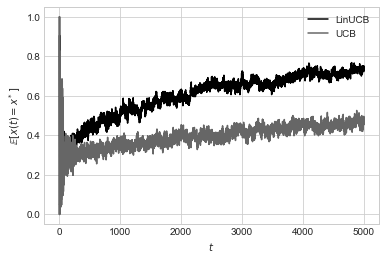

In [12]:
agent_classes = [LinUCBAgent, UCBAgent]
n_arms = len(arms)
n_iter = 500
n_step = 5000
selected_arms = np.zeros(
    (n_iter, len(agent_classes), n_step), dtype=int)
earned_rewards = np.zeros(
    (n_iter, len(agent_classes), n_step), dtype=int)
for it in range(n_iter):
  for i, agent_class in enumerate(agent_classes):
    agent = agent_class()
    for step in range(n_step):
      arm_index = agent.get_arm()
      arm = arms[arm_index]
      reward = Env.react(arm)
      agent.sample(arm_index, reward)
      selected_arms[it, i, step] = arm_index
      earned_rewards[it, i, step] = reward

acc = np.mean(selected_arms==Env.opt(), axis=0)
plt.plot(acc[0], label='LinUCB')
plt.plot(acc[1], label='UCB')
plt.xlabel(r'$t$')
plt.ylabel(r'$\mathbb{E}[x(t) = x^*]$')
plt.legend()
plt.show()

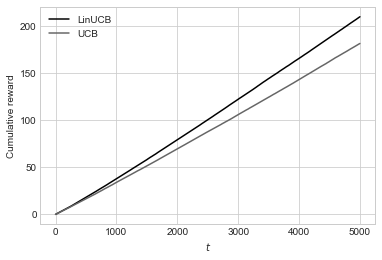

In [13]:
plt.plot(np.mean(np.cumsum(earned_rewards, axis=2), axis=0)[0],
          label='LinUCB')
plt.plot(np.mean(np.cumsum(earned_rewards, axis=2), axis=0)[1],
          label='UCB')
plt.xlabel(r'$t$')
plt.ylabel('Cumulative reward')
plt.legend()
plt.show()